## Output has been removed from this notebook to reduce file sizes in the repo

In [109]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pandana as pdna
from pandana.loaders import osm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download OpenStreetMap restaurants for a good part of the Bay Area

###### Note: used http://boundingbox.klokantech.com/ to get the bounding box

In [110]:
# Bounding box from link above

# CSV for Aveiro
tmp = [-8.773076,40.546452,-8.593617,40.677114]

# Reordered for Pandana functions
bbox = [tmp[1], tmp[0], tmp[3], tmp[2]]

network = osm.pdna_network_from_bbox(*bbox)
poi_df = osm.node_query(*bbox, tags='amenity=school')
x, y = poi_df['lon'], poi_df['lat']
# store = poi_df.


Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](40.54645200,-8.77307600,40.67711400,-8.59361700);>;);out;'}"
Downloaded 5,560.6KB from www.overpass-api.de in 1.21 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 1.43 seconds
Returning OSM data with 40,615 nodes and 6,943 ways...
Edge node pairs completed. Took 16.95 seconds
Returning processed graph with 8,904 nodes and 12,755 edges...
Completed OSM data download and Pandana node and edge table creation in 21.89 seconds


In [111]:

network.set_pois('schools', 2000, 10, x,y)
network.save_hdf5('data/aveiro2.h5')
# x, y = poi_df['lon'], poi_df['lat']


## Get previously stored OpenStreetMap networks for Bay Area

Download the data here: https://s3-us-west-1.amazonaws.com/synthpop-data2/pandana/osm_bayarea.h5

In [112]:
store = pd.HDFStore('data/aveiro.h5', "r")
# store = network
nodes = store.nodes
edges = store.edges
print(nodes.head(3))
print(edges.head(3))
edges

                  x          y
id                            
26019656  -8.684921  40.632523
132887998 -8.725343  40.639438
267983421 -8.746970  40.633751
                           from          to    distance
26019656  1650473977   26019656  1650473977  202.986370
132887998 624272810   132887998   624272810  101.755323
          1650269783  132887998  1650269783    9.057816


from          to    distance
26019656   1650473977    26019656  1650473977  202.986370
132887998  624272810    132887998   624272810  101.755323
           1650269783   132887998  1650269783    9.057816
267983421  3603994746   267983421  3603994746    2.749155
           3603994747   267983421  3603994747    2.784190
267983422  3603994769   267983422  3603994769    2.825462
267983429  1214724417   267983429  1214724417   40.890244
           1214724466   267983429  1214724466    6.775382
267983444  3596762941   267983444  3596762941   39.123814
330341298  1484655928   330341298  1484655928  151.385838
330341301  330341302    330341301   330341302  115.117222
           1484930831   330341301  1484930831   72.416663
330341302  698090406    330341302   698090406   72.958899
           5217907851   330341302  5217907851   15.840054
330341303  1406433057   330341303  1406433057    9.879029
           1650941224   330341303  1650941224   29.699161
330341306  390280425    330341306   390280425   32.642863
           1489699007   330341306  1489699007   22.144065
330341308  330341607    330341308   330341607   19.187207
330341455  1110673533   330341455  1110673533  250.459604
330341607  385009969    330341607   385009969   36.551098
           1650541330   330341607  1650541330   28.511832
336969591  5291528487   336969591  5291528487   13.345122
336969608  1650513889   336969608  1650513889   55.861982
           1678492657   336969608  1678492657   49.306300
336969639  339535442    336969639   339535442   16.304483
336969645  1650513801   336969645  1650513801   25.369618
336969728  1315886924   336969728  1315886924  145.879812
           1384272475   336969728  1384272475  156.193826
           4705756479   336969728  4705756479  212.884611
...                           ...         ...         ...
5802437568 5802437576  5802437568  5802437576  270.688925
5802437576 5802437617  5802437576  5802437617  166.279103
5802437617 1650475114  5802437617  1650475114  201.852541
5802437631 1650475114  5802437631  1650475114  142.164016
5802554517 5802554568  5802554517  5802554568   87.988790
5802554534 1604822241  5802554534  1604822241   93.529969
           5802554517  5802554534  5802554517  292.430259
5802554549 5802554550  5802554549  5802554550    4.797055
           5802554568  5802554549  5802554568  205.679834
5802554550 1604822042  5802554550  1604822042   32.484978
5802554568 5802554550  5802554568  5802554550  203.164214
5818226229 5818226232  5818226229  5818226232    6.973640
5818226230 5818226233  5818226230  5818226233    1.481994
5818226232 5818226230  5818226232  5818226230    7.109531
5818226233 5818226236  5818226233  5818226236   13.487368
5818226236 5818226229  5818226236  5818226229    1.706476
5860772648 1950917587  5860772648  1950917587  319.740422
           1950917641  5860772648  1950917641  329.353733
5860772787 1650688017  5860772787  1650688017   44.981868
           1950916965  5860772787  1950916965   63.199860
6024660632 6024660648  6024660632  6024660648    3.759485
6024660636 2882692732  6024660636  2882692732   53.442290
           6024660632  6024660636  6024660632   49.795512
6024660643 2882693752  6024660643  2882693752   49.310749
6024660648 2882692749  6024660648  2882692749   18.011419
           6024660643  6024660648  6024660643   54.549154
6041871529 4568439461  6041871529  4568439461  112.483959
6041874980 3414343744  6041874980  3414343744   50.726923
           6041871529  6041874980  6041871529   57.963103
6041878083 6041874980  6041878083  6041874980   57.363835

[9858 rows x 3 columns]

## Initialize and preprocess the network

In [113]:
net=pdna.Network(nodes.x, 
                 nodes.y, 
                 edges["from"], 
                 edges["to"],
                 edges[["distance"]])
net.precompute(3000)

## Nearest *point-of-interest* queries

In [114]:

net.set_pois("schools", 2000, 10, x, y)

In [115]:
a = net.nearest_pois(2000, "schools", num_pois=10)
print(a.head(1))

              1       2       3       4       5       6       7       8   \
id                                                                         
26019656  2000.0  2000.0  2000.0  2000.0  2000.0  2000.0  2000.0  2000.0   

              9       10  
id                        
26019656  2000.0  2000.0  


## Here's a map of the distance to the nearest restaurant

(<mpl_toolkits.basemap.Basemap at 0x7f80f300bf60>,
 <Figure size 2880x2160 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80f3393208>)

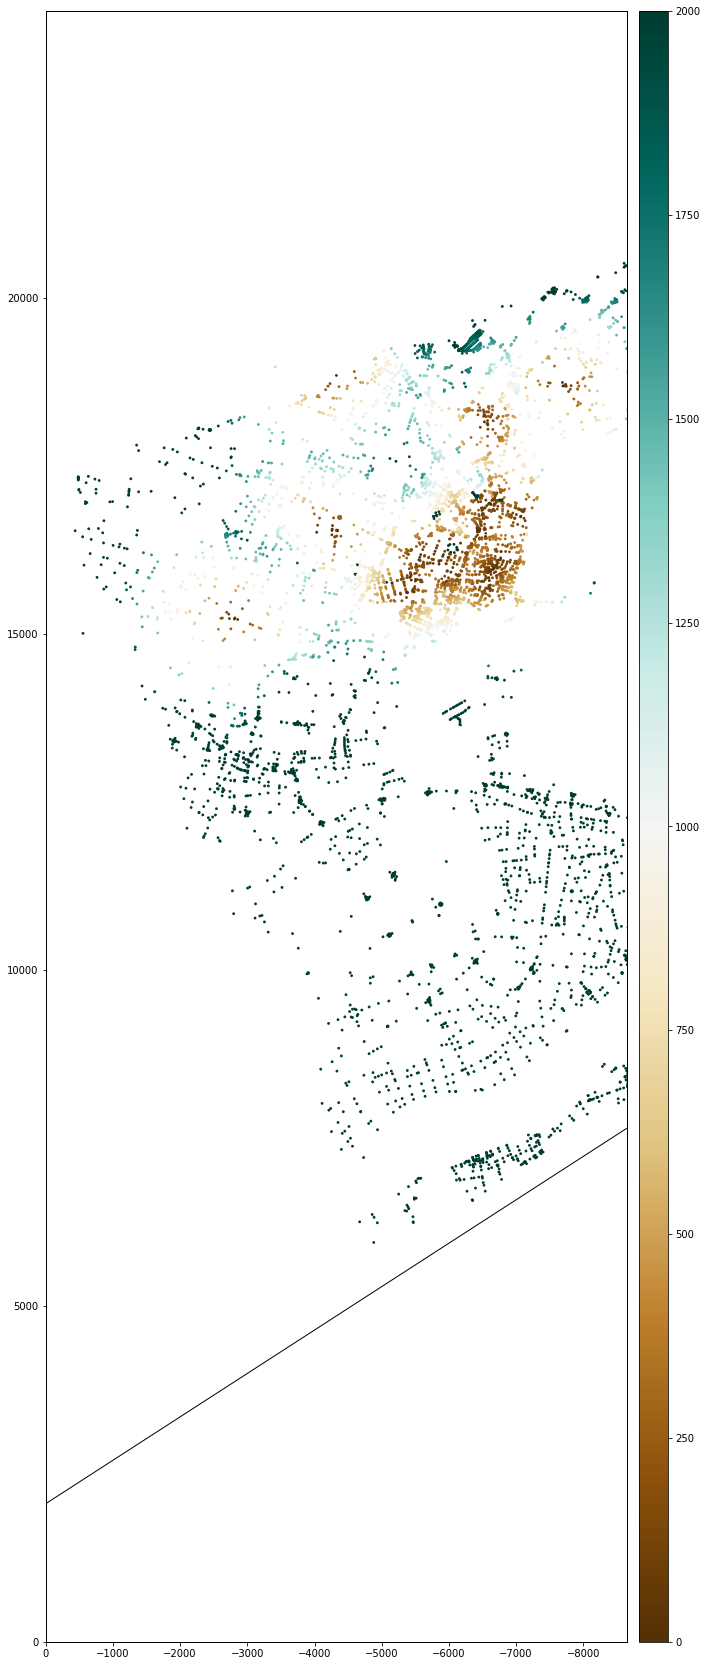

In [119]:
fig_kwargs = {'figsize': [40, 30]}
bmap_kwargs = {'suppress_ticks': False, 'resolution': 'h', 'epsg': '26943'}
plot_kwargs = {'cmap': 'BrBG', 's': 8, 'edgecolor': 'none'}

sf_tmp = [-8.800068,40.533581,-8.571186,40.68614]
sf_bbox = [sf_tmp[1], sf_tmp[0], sf_tmp[3], sf_tmp[2]]

net.plot(a[1], bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Here's a map of the distance to the 5th nearest restaurant

In [117]:
net.plot(a[0], bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

KeyError: 0

## Here's a map of the distance to the 10th nearest restaurant

In [ ]:
net.plot(a[10], bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

# A similar workflow is used to do general network aggregations

## Relate the x-ys to nodes

In [ ]:
node_ids = net.get_node_ids(x, y)

## Assign the variable (in this case just location) to the network

In [ ]:
net.set(node_ids)

## This is it - run the queries!

In [ ]:
%time s = net.aggregate(500, type="sum", decay="linear")
%time t = net.aggregate(1000, type="sum", decay="linear")
%time u = net.aggregate(2000, type="sum", decay="linear")
%time v = net.aggregate(3000, type="sum", decay="linear")
%time w = net.aggregate(3000, type="count", decay="flat")

## Here's a map of access to restaurants with a 500m radius

In [ ]:
net.plot(s, bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Or 1000 meters

In [ ]:
net.plot(t, bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Or 2000 meters radius

In [ ]:
net.plot(u, bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Or 3000m radius

In [ ]:
net.plot(v, bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Or the whole Bay Area region

In [ ]:
net.plot(w, bbox=bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)